In [1]:
import numpy as np
np.random.seed(13)

from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
from gensim.models.doc2vec import Word2Vec

### k.mean( )で必要になるので追加
from keras import backend as K

import checkhinsi3 as chk

Using Theano backend.


In [2]:
import os
#path = "/local/home/hina/gitrepos/EddCorpus/Dazai_Osamu/wakati/preproc/hashire_merosu.txt.utf8.ped.wakati.wID"
path = "/local/home/hina/gitrepos/EddCorpus/Dazai_Osamu/wakati/preproc/test.wID"
root, ext = os.path.splitext(path)

# type(my_wID[1]): <type 'list'>
my_wID = chk.readfile(path, "lines", "wID")
# type(my_phrase[1]): <type 'list'>
my_phrase = chk.readfile(root + ".phrase", "lines", "phrase")

In [3]:
base_filter()
#path = 'wakati.tmp'
#corpus = open(path).readlines()[0:500]
corpus = chk.splitwID2phrase(my_wID, my_phrase)

### new line more than 2 を削除
#corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

### base_filter に ' を追加
#tokenizer = Tokenizer(filters=base_filter()+"'")

### corpus を整形
#tokenizer.fit_on_texts(corpus)

### corpus の型を sequence に変更（file 出力できなかった）
#corpus = tokenizer.texts_to_sequences(corpus)

### sequence の合計を nb_samples に代入
#nb_samples = sum(len(s) for s in corpus)

### 語彙数を数える
#V = len(tokenizer.word_index) + 1
V = 35855

### 多分、特徴ベクトルの次元数
dim = 100

### 文脈窓
window_size = 2

In [44]:
i = 0
for phrase in corpus:
    if i <= 5:
        print "**************"
        print phrase
        for i in range(0, len(phrase)):
            print phrase[i]
    i += 1

**************
[['25471'], ['11446']]
['25471']
['11446']
**************
[['25814'], ['20377']]
['25814']
['20377']
**************
[['477'], ['11642']]
['477']
['11642']
**************
[['20754'], ['32051']]
['20754']
['32051']
**************
[['494'], ['477'], ['11642', '6488'], ['30788'], ['31306'], ['34373', '6488'], ['19775', '9340'], ['28693'], ['4338'], ['15218']]
['494']
['477']
['11642', '6488']
['30788']
['31306']
['34373', '6488']
['19775', '9340']
['28693']
['4338']
['15218']


In [30]:
### CBOW の定義
def generate_data_bak(corpus, window_size, V):
    maxlen = window_size*2
    
    ### コーパス内の単語数だけ繰り返す
    for phrase in corpus:
        ### リストを生成
        contexts = []
        labels   = []
        L = len(phrase)
        
        ### index: 注目する単語の番号
        for index, words in enumerate(phrase):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([phrase[i] for i in range(s, e) if 0 <= i < L and i != index])
            print "contexts.type: ", type(contexts)
            
            ### contexts は文脈窓範囲内の単語の ID が格納されたリスト
            print "context: ", contexts[index]
            
            for word in words:
                labels.append(word)
            
            ### x はシーケンス型、着目する単語の窓範囲内のwordIDを格納したcontexts
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            

            y = chk.onehotvec(phrase, 35855)
            ### 1 of K 表現に変換
            ### y: シーケンス型、V 次元のベクトルを、contexts だけもつ行列
            ### x を 1 of K 表現にしたもの?
            yield (x, y)

In [17]:
### CBOW の定義
def generate_data_bak2(corpus, window_size, V):
    maxlen = window_size*2
    
    ### コーパス内の単語数だけ繰り返す
    for phrase in corpus:
        ### リストを生成
        contexts = []
        labels   = []
        L = len(phrase)
        print "****************************************"
        print "phrase: ",
        print phrase
        ### index: 注目する単語の番号
        for index, words in enumerate(phrase):
            s = index-window_size
            e = index+window_size+1
            #contexts.append([phrase[i] for i in range(s, e) if 0 <= i < L and i != index])
            print phrase[index]
            for i in range(s, e):
                if ( (0 <= i < L) and (i != index) ):
                    print "len: ",
                    print len(phrase[i])

                    if len(phrase[i]) <= 1:
                        print "phrase[i]: ",
                        print phrase[i]
                        print type(phrase[i])
                        contexts.append(phrase[i])
                    else:
                        for word in phrase[i]:
                            print "Expected:"
                            print "word: ",
                            print type(word),
                            print word
                            tmp = []
                            tmp += list(word)
                            tmp2 = "".join(tmp)
                            print tmp2
                            tmp3 = []
                            tmp3.append(tmp2)
                            print tmp3
                            print type(tmp3)
                            contexts.append(tmp3)
            
            print "contexts: ", contexts
            newcon = []
            temp = []
            i1 = 0
            i2 = 0
            for a1 in contexts:
                for a2 in a1:
                    for a3 in a2:
                        temp.append(a3)
                    newcon.append(temp)
                    temp = []
                        
            ### contexts は文脈窓範囲内の単語の ID が格納されたリスト
            print "context: ", newcon[index]
            
            for word in words:
                labels.append(word)
            
            ### x はシーケンス型、着目する単語の窓範囲内のwordIDを格納したcontexts
            x = sequence.pad_sequences(newcon, maxlen=maxlen)
            
            ### 1 of K 表現に変換
            ### y: シーケンス型、V 次元のベクトルを、contexts だけもつ行列
            ### x を 1 of K 表現にしたもの?
            y = chk.onehotvec(phrase, 35855)
            yield (x, y)

In [92]:
### CBOW の定義
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    
    ### コーパス内の単語数だけ繰り返す
    for phrase in corpus:
        ### リストを生成
        contexts = []
        newcon = []
        ite = 0
        labels   = []
        L = len(phrase)
        print "****************************************"
        print "phrase: ",
        print phrase
        ### index: 注目する単語の番号
        for index, words in enumerate(phrase):
            s = index-window_size
            e = index+window_size+1
            #contexts.append([phrase[i] for i in range(s, e) if 0 <= i < L and i != index])
            for i in range(s, e):
                if ( (0 <= i < L) and (i != index) ):
                    print "len: ",
                    print len(phrase[i])
                    if len(phrase[i]) <= 1:
                        print "phrase[i]: ",
                        print phrase[i]
                        contexts.append(phrase[i])
                    else:
                        for word in phrase[i]:
                            print "Expected:"
                            tmp = []
                            tmp += list(word)
                            tmp2 = "".join(tmp)
                            tmp3 = []
                            tmp3.append(tmp2)
                            print "tmp3: ",
                            print tmp3
                            contexts.append(tmp3)
            
            newcon1 = []
            for a2 in contexts:
                for a1 in a2:
                     newcon1.append(a1)
            newcon2 = map(int, newcon1)
            print "contexts: ", newcon
    
            newcon.append(newcon2)
            print "contexts: ", newcon
    
            ### contexts は文脈窓範囲内の単語の ID が格納されたリスト
            ### x はシーケンス型、着目する単語の窓範囲内のwordIDを格納したcontexts
            x = sequence.pad_sequences(newcon, maxlen=maxlen)
            
            ### 1 of K 表現に変換
            ### y: シーケンス型、V 次元のベクトルを、contexts だけもつ行列
            ### x を 1 of K 表現にしたもの?
            y = chk.onehotvec(phrase, 35855)
            yield (x, y)

In [43]:
a = [[[1,2], [3,4], [5, 6]]]
b = []
c = []
for x in a:
    print "x: ",
    print x
    for y in x:
        print "y: ",
        print y
        for z in y:
            print "z: ",
            print z
            b.append(z)
        print "b: ",
        print b
        c.append(b)
        b = []
print ;
print c

for x in a:
    

x:  [[1, 2], [3, 4], [5, 6]]
y:  [1, 2]
z:  1
z:  2
b:  [1, 2]
y:  [3, 4]
z:  3
z:  4
b:  [3, 4]
y:  [5, 6]
z:  5
z:  6
b:  [5, 6]

[[1, 2], [3, 4], [5, 6]]


In [93]:
for x, y in generate_data(corpus, window_size, V):
    print "x: ",
    print type(x),
    print ;
    print x
    print "y: ",
    print type(y)

****************************************
phrase:  [['25471'], ['11446']]
len:  1
phrase[i]:  ['11446']
contexts:  []
contexts:  [[11446]]
x:  <type 'numpy.ndarray'>
[[    0     0     0 11446]]
y:  <type 'numpy.ndarray'>
len:  1
phrase[i]:  ['25471']
contexts:  [[11446]]
contexts:  [[11446], [11446, 25471]]
x:  <type 'numpy.ndarray'>
[[    0     0     0 11446]
 [    0     0 11446 25471]]
y:  <type 'numpy.ndarray'>
****************************************
phrase:  [['25814'], ['20377']]
len:  1
phrase[i]:  ['20377']
contexts:  []
contexts:  [[20377]]
x:  <type 'numpy.ndarray'>
[[    0     0     0 20377]]
y:  <type 'numpy.ndarray'>
len:  1
phrase[i]:  ['25814']
contexts:  [[20377]]
contexts:  [[20377], [20377, 25814]]
x:  <type 'numpy.ndarray'>
[[    0     0     0 20377]
 [    0     0 20377 25814]]
y:  <type 'numpy.ndarray'>
****************************************
phrase:  [['477'], ['11642']]
len:  1
phrase[i]:  ['11642']
contexts:  []
contexts:  [[11642]]
x:  <type 'numpy.ndarray'>
[[ 

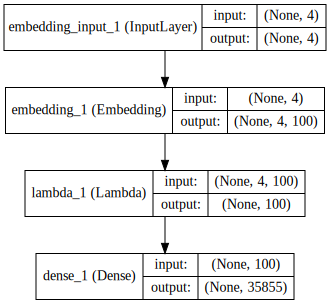

In [6]:
### ネットワーク構造をシーケンシャルに
cbow = Sequential()

### 入力層は Embeddding で固定次元に変換
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))

### 入力層の出力を、dim 次元ベクトルの平均値にする
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))

### dim 次元に変換された 4 つの単語を入力とする第二層
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))

###  スケーラブル・ベクター・グラフィックを生成、表示
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
### 学習過程の確認
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")

## cbow.train_on_batch(x, y)

#### x: 入力データ、Numpy 配列または Numpy 配列のリスト (モデルに複数の入力がある場合)。
#### y: ラベル、Numpy 配列の形式。

In [8]:
### 学習開始
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        print "x: ",
        print type(x),
        print ;
        print x
        print "y: ",
        print type(y),
        print ;
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)

****************************************
phrase:  [['25471'], ['11446']]
context:  [['11446']]
x:  <type 'numpy.ndarray'>
[[[    0]
  [    0]
  [    0]
  [11446]]]
y:  <type 'numpy.ndarray'>


Exception: Error when checking model input: expected embedding_input_1 to have 2 dimensions, but got array with shape (1, 4, 1)

In [19]:
### 学習開始
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        print "x: ",
        print type(x),
        print ;
        print x
        print "y: ",
        print type(y),
        print ;
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)



words:  [8, 1]
contexts.type:  <type 'list'>
context:  [1]
x:  <type 'numpy.ndarray'>
[[0 0 0 1]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
contexts.type:  <type 'list'>
context:  [8]
x:  <type 'numpy.ndarray'>
[[0 0 0 1]
 [0 0 0 8]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


words:  [4, 7]
contexts.type:  <type 'list'>
context:  [7]
x:  <type 'numpy.ndarray'>
[[0 0 0 7]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
contexts.type:  <type 'list'>
context:  [4]
x:  <type 'numpy.ndarray'>
[[0 0 0 7]
 [0 0 0 4]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


words:  [5, 1, 6, 10, 3, 2, 9]
contexts.type:  <type 'list'>
context:  [1, 6]
x:  <type 'numpy.ndarray'>
[[0 0 1 6]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
contexts.type:  <type 'l

In [49]:
### 書き込み用ファイルを生成
f = open("vectors.txt", "w")

### 語彙数と特徴ベクトルの次元数を書き込む
#f.write( " ".join([str(V-1), str(dim)]) )
#f.write("\n")

In [7]:
vectors = cbow.get_weights()[0]

### 学習で得られた単語の特徴ベクトルを書き込む
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

NameError: name 'f' is not defined

In [8]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [21]:
simResult = w2v.most_similar(positive=[u"疑う"])
for x in simResult:
    print x[0], x[1];

心 0.760085880756
取り直し 0.660530209541
願い 0.650048851967
様 0.64907169342
懐中 0.615660429001
心構え 0.612200021744
真紅 0.60736900568
帰り 0.592604875565
殺し 0.589504122734
牧人 0.588057458401
